<a href="https://colab.research.google.com/github/paras9o9/MachineLearning/blob/main/LifeExpectancyPrediction/LEP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Dropped Highly Correlated Features:
 ['under-five deaths', 'GDP', 'thinness 5-9 years', 'Schooling']


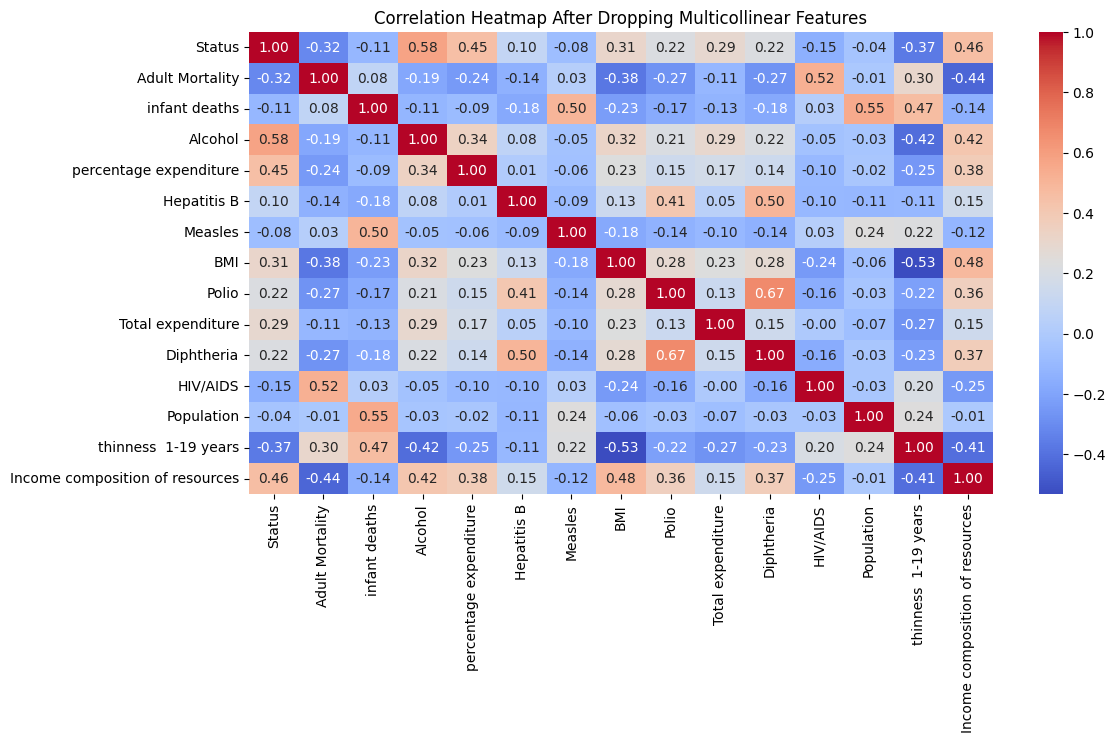


Mutual Information Scores:
 Adult Mortality                    1.276154
Income composition of resources    0.927873
thinness  1-19 years               0.776267
BMI                                0.573379
HIV/AIDS                           0.529115
infant deaths                      0.421296
Alcohol                            0.344561
Polio                              0.329151
Diphtheria                         0.309262
percentage expenditure             0.295768
Total expenditure                  0.258524
Hepatitis B                        0.204261
Status                             0.203641
Population                         0.154944
Measles                            0.124802
dtype: float64

Top 10 Selected Features by RFE:
 Index(['Status', 'Adult Mortality', 'Alcohol', 'BMI', 'Polio',
       'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'thinness  1-19 years',
       'Income composition of resources'],
      dtype='object')

Variance Inflation Factor (VIF) for Selected Features:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load dataset-
df = pd.read_csv("/content/LEP.csv")

# Drop non-relevant columns
# Drop specified labels from rows or columns.
# Remove rows or columns by specifying label names and corresponding
# axis, or by directly specifying index or column names.
df = df.drop(columns=["Country", "Year"])

# Encode categorical feature (Developing = 0, Developed = 1)
# Status (Developing/Developed) is converted to numeric (0/1).
df["Status"] = df["Status"].map({"Developing": 0, "Developed": 1})

# Handle missing values (fill with column mean)
# Missing values are filled with the mean to avoid errors in calculations.
# We replace NaN values with the mean of each column to maintain data consistency.
df = df.fillna(df.mean())

# "Machine Learning models require numerical data—this encoding makes it possible."

# Define X (features) and y (target variable)
X = df.drop(columns=["Life expectancy"])
y = df["Life expectancy"]

### 1. Removing Multicollinear Features using Correlation ###
### This part of the code helps in removing highly correlated feartures to aovid multicollinearity, which can negativily impact linear regression.
# Defines a threshold (0.75) for considering two features as "highly correlated."
# If the correlation between two features > 0.75, we consider them too similar and remove one.

# 0.75–1.0 → Strong correlation (remove one feature).
# 0.5–0.75 → Moderate correlation (might still affect the model).
# 0.0–0.5 → Weak correlation (good for independent features).
correlation_threshold = 0.75  # Adjust if needed
# X.corr() calculates correlations between all features in X.
#.abs() takes the absolute value, ensuring we consider both positive and negative correlations equally.
corr_matrix = X.corr().abs()

# Find highly correlated features
# where() keeps only values in the upper triangle, setting the rest to NaN.
# (np.triu(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))) Creates a mask for the upper triangle of the matrix.=
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Scans each column in upper_traingle to find feature with correlation > 0.75. Stores them in highly_correlated list.
highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]

# Drop correlated features
# Removes all features listed in highly_correlated.
# The dataset now has only independent features.
X = X.drop(columns=highly_correlated)
print("\nDropped Highly Correlated Features:\n", highly_correlated)

# Plot Correlation Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap After Dropping Multicollinear Features")
plt.show()

### 2. Checking Feature Relevance using Mutual Information ###
### This part of the code helps determine how much each feature contributes to predicting life Expectancy. ###
# Mutual Inforamtion (MI) measures the dependency between a featureand the target variable (y = Life Expectancy)
# MI is non-linear, meaning it can detect complex relationships between features and the target.
# Unlike correlation, MI can detect both linear and non-linear dependencies.

# It calculates the MI score for each feature in X with respect to y (Life Expectacny)
mi_scores = mutual_info_regression(X, y)
# Sorts features in descending order.
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("\nMutual Information Scores:\n", mi_scores)

### 3. Selecting Features using Recursive Feature Elimination (RFE) ###
### Recursive Feature Elimination (RFE) is a wrapper method that iterativly removes the least important feature until only the best ones remain. ###
### It helps identify which features contribute the most to predicting Life Expextancy.

# Defines a Linear REgression model to evaluate feature importance.
# RFE will use this model to determine which features are most useful.
model = LinearRegression()
# Selecting the top 1- features that contribute the most to predicting y.
# Selecting number of feature depends on how many features your dataset has.
rfe = RFE(model, n_features_to_select=10)  # Select top 10 features
# Trains the RFE model using x (features) and y (Life Expectancy).
# Iterativly removes the least important features until only 10 remain.
rfe.fit(X, y)
selected_features_rfe = X.columns[rfe.support_]
print("\nTop 10 Selected Features by RFE:\n", selected_features_rfe)

### 4. Checking for Multicollinearity using VIF (Variance Inflation Factor) ###
### VIF measures how much a feature is correlated with other features.
### A high VIF (>5 or 10) means the feature is highly correlate with others and should be removed.

# "Multicollinearity is bad for linear regression because it makes it hard to determine the true impact of each feature."
# Keeps only the 10 best features chosen by RFE.
X_selected = X[selected_features_rfe]  # Keep only RFE-selected features
# Creates an empty DataFrame called vif_data and adds a "feature" column containing the names of selected features.
vif_data = pd.DataFrame()
vif_data["Feature"] = X_selected.columns
# Calculates VIF for each feature using variance_inflation_factor().
vif_data["VIF"] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]
print("\nVariance Inflation Factor (VIF) for Selected Features:\n", vif_data)

### 5. Standardizing Features for Linear Regression (Optional) ###
### Linear Regression models works better when features have similar scales.
### Standardization ensures all features are on the same scale by converting them to zero mean and unit variance.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Convert the scaled NumPy array back to a pandas DataFrame.
# Keeps the column names se we know which features are included.
X_final = pd.DataFrame(X_scaled, columns=selected_features_rfe)

print("\nFinal Selected Features Ready for Linear Regression:\n", X_final.head())


In [3]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make prediction
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R² Score): {r2:.2f}")


Model Evaluation:
Mean Squared Error (MSE): 18.81
R-squared (R² Score): 0.78


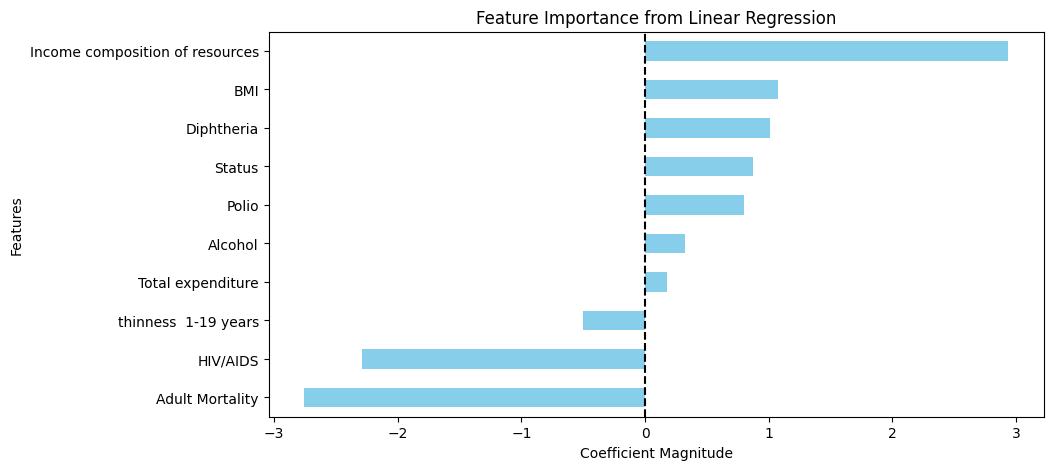

In [4]:
# Get the feature importance for the model
feature_importance = pd.Series(model.coef_, index=X_train.columns).sort_values()

# PLot the feature importance
plt.figure(figsize=(10, 5))
feature_importance.plot(kind="barh", color="skyblue")
plt.title("Feature Importance from Linear Regression")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Features")
plt.axvline(0, color="black", linestyle="--")
plt.show()

In [5]:
# Creating Interaction terms
df["BMI_Alcohol"] = df["BMI"] * df["Alcohol"]
df["Mortality_HIV"] = df["Adult Mortality"] * df["HIV/AIDS"]
df["Income_Schooling"] = df["Income composition of resources"] * df["Schooling"]
df["Polio_Diphtheria"] = df["Polio"] * df["Diphtheria"]

# Add new feature to X
X["BMI_Alcohol"] = df["BMI_Alcohol"]
X["Mortality_HIV"] = df["Mortality_HIV"]
X["Income_Schooling"] = df["Income_Schooling"]
X["Polio_Diphtheria"] = df["Polio_Diphtheria"]

In [6]:
from sklearn.preprocessing import PolynomialFeatures

# Applying Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X)

# Convert back to the DataFrame
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.columns))

In [7]:
X["log_Population"] = np.log1p(X["Population"]) # log1p avoids log(0) issues
X["sqrt_Expenditure"] = np.sqrt(X["Total expenditure"])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Updated MSE: {mse:.2f}")

Updated MSE: 15.13


In [9]:
# Evaluated R2 Score
r2 = r2_score(y_test, y_pred)
print(f"Updated R² Score: {r2:.2f}")

Updated R² Score: 0.83


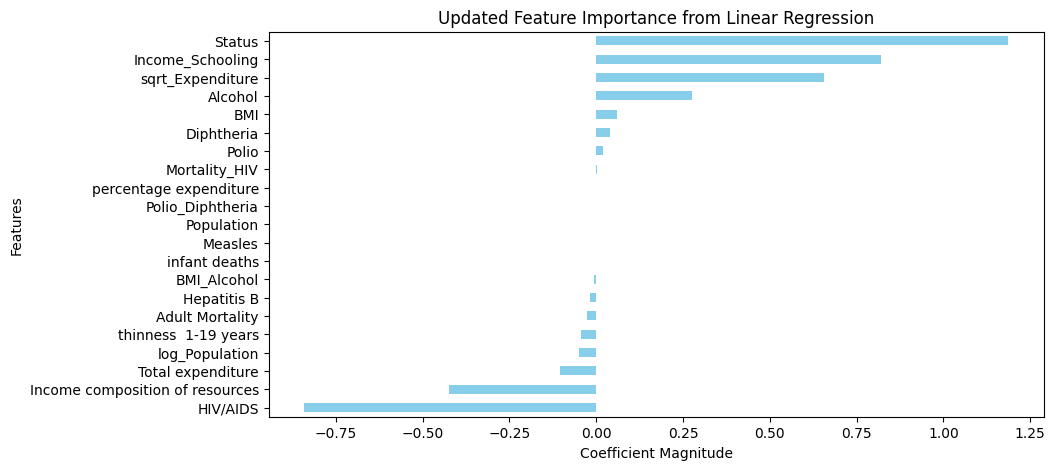

In [10]:
feature_importance = pd.Series(model.coef_, index=X_train.columns).sort_values()

plt.figure(figsize=(10, 5))
feature_importance.plot(kind="barh", color="skyblue")
plt.title("Updated Feature Importance from Linear Regression")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Features")
plt.show()

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame to stroe VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Display VIF Values
print(vif_data)

                            Feature         VIF
0                            Status    2.503419
1                   Adult Mortality    6.394823
2                     infant deaths    2.127032
3                           Alcohol   16.561318
4            percentage expenditure    1.587847
5                       Hepatitis B   19.539131
6                           Measles    1.401660
7                               BMI   15.473493
8                             Polio   88.181522
9                 Total expenditure  130.082021
10                       Diphtheria   90.109510
11                         HIV/AIDS    4.938600
12                       Population    1.511929
13             thinness  1-19 years    4.336748
14  Income composition of resources   99.187396
15                      BMI_Alcohol   17.893176
16                    Mortality_HIV    5.653830
17                 Income_Schooling   63.745972
18                 Polio_Diphtheria  124.453143
19                   log_Population   33